# Team 4 Analysis

By Melita, Dani and Rose

### Contents

**0. [Imports and functions](#0.-Imports-and-functions)**

**1. [Preprocessing the data](#1.-Preprocessing-the-data)**

1.1 [Understanding the data](#1.1-Understanding-the-data)

1.2 [Checking for missing data](#1.2-Checking-for-missing-data)

1.3 [Dealing with outliers](#1.3-Dealing-with-outliers)

1.4 [Encoding categorical data](#1.4-Encoding-categorical-data)

1.5 [Feature scaling](#1.5-Feature-scaling)

1.6 [Splitting into train and test data](#1.6-Splitting-into-train-and-test-data)

1.7 [Determining the threshold](#1.7-Determining-the-threshold)
        
**2. [Logistic Regression model](#2.-Logistic-Regression-model)**

2.1

2.2

2.3
    
**3. [Decision Tree model](#3.-Decision-Tree-model)**

3.1

3.2

3.3
    
**4. [Random Forest model](#4.-Random-Forest-model)**

4.1 [Tuning the hyperparameters](4.1-Tuning-the-hyperparameters)

4.2 [Running the model](#4.2-Running-the-model)

4.3 [Evaluating the model](#4.3-Evaluating-the-model)

**5. [Nueral network](#5.-Neural-network)**

5.1

5.2

5.3

**6. [Conclusion](#6.-Conclusion)**

6.1 [Comparing the models side-by-side](#6.1-Comparing-the-models-side-by-side)

6.2 [Recommendations for future work](#6.2-Recommendations-for-future-work)

**7. [References](#7.-References)**

## 0. Imports and functions

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn import metrics

import matplotlib.pyplot as plt
from sklearn.metrics import (auc, confusion_matrix, roc_curve, 
                             accuracy_score, precision_score)
from pprint import pprint
from sklearn.model_selection import RandomizedSearchCV
from itertools import product

Function for displaying accuracy, precision and AUC:

In [2]:
def print_metrics(y_test,pred_clf,proba_clf, classifier_name):
    
    """
    This function prints accuracy, precision and AUC
    
    Inputs:
    
    y_test is a series with the labels of the test data
    
    pred_clf is a numpy.ndarray with the predictions of the model
    
    proba_clf is a numpy.ndarray with the probabilities calculated by the model
    
    classifier_name is the name of the classifier which will appear in the text
    
    No outputs
    
    """
    
    # Print accuracy and precision
    tn, fn, fp, tp = confusion_matrix(y_test, pred_clf).ravel()
    
    acc = round((tp + tn) / X_test.shape[0], 3) * 100
    print('{0} accuracy: {1:.2f}%'.format(classifier_name, acc))
    
    precision = round((tp / (tp + fp)), 2) * 100
    print('{0} precision: {1:.2f}%'.format(classifier_name, precision))
    
    # Print AUC
    auc = metrics.roc_auc_score(y_test, proba_clf[:,1])
    print("{0} AUC: {1:.4f}".format(classifier_name, auc))
    
    return None

Function for displaying the confusion matrix, edited from [n].

In [3]:
# Function to display the confusion matrix

def plot_confusion_matrix(cm,
                          normalize=False,
                          axis=1,
                          figsize=(5,4), 
                          fontsize=14,
                          cmap='Blues'):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    Note that normalization here by default occurs across axis=1, or across each row (true class). 
    (QQ: which metric does this correspond to, precision or recall?)
    """
    classes = ['Benign', 'Malignant']
    
    if normalize:
        if axis == 1:
            cm = cm.astype('float') / cm.sum(axis=axis)[:, np.newaxis]
        elif axis == 0:
            cm = cm.astype('float') / cm.sum(axis=axis)[np.newaxis, :]
        else:
            raise ValueError("axis must be 0 or 1")
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    
    fig = plt.figure(figsize=figsize)
    plt.grid(b=None)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    q_labels = ['TN', 'FP', 'FN', 'TP']
    quad_font_size = 14
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    q_i = 0
    for i, j in product(range(cm.shape[0]), range(cm.shape[1])):
        
        q = plt.text(j, i-0.2, q_labels[q_i], horizontalalignment='center', fontsize=quad_font_size)
        q_i += 1
        q.set_bbox(dict(facecolor='white', alpha=0.6, edgecolor='white'))
        
        t = plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                     verticalalignment="center",
                 color="#002781",
                    fontsize=fontsize)
        t.set_bbox(dict(facecolor='white', alpha=0.6, edgecolor='white'))
        

    plt.tight_layout(h_pad=10, w_pad=0)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    return None

Function for plotting feature importance.

In [4]:
def plot_feature_importance(clf, colour, classifier_name):
    
    """
    This function plots feature importance
    
    Inputs:
    
    clf is the classifier
    
    colour is a string describing the colour the bars should be
    
    classifier_name is the name of the classifier which will appear in the title
    
    No outputs
    
    """
    
    features_log = pd.DataFrame(clf.feature_importances_, index = one_hot_df_indep.columns.tolist(), 
                            columns = ['Importance'])
    features_log = features_log.sort_values(by='Importance', ascending=True)

    features_log.plot(kind='barh', figsize=(12,9), color = colour)
    plt.xlabel('Feature importance')
    plt.title('Feature importance for {}'.format(classifier_name))
    
    return None

Set the global variable for the random state seed.

In [5]:
global SEED
SEED = 42

## 1. Preprocessing the data

### 1.1 Understanding the data

In [6]:
# Load data
df_raw = pd.read_csv("data.csv", index_col=[0])
df_raw.head()

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
id,,,,,,,,,,,,,,,,,,,,,
842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


In [7]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 569 entries, 842302 to 92751
Data columns (total 32 columns):
diagnosis                  569 non-null object
radius_mean                569 non-null float64
texture_mean               569 non-null float64
perimeter_mean             569 non-null float64
area_mean                  569 non-null float64
smoothness_mean            569 non-null float64
compactness_mean           569 non-null float64
concavity_mean             569 non-null float64
concave points_mean        569 non-null float64
symmetry_mean              569 non-null float64
fractal_dimension_mean     569 non-null float64
radius_se                  569 non-null float64
texture_se                 569 non-null float64
perimeter_se               569 non-null float64
area_se                    569 non-null float64
smoothness_se              569 non-null float64
compactness_se             569 non-null float64
concavity_se               569 non-null float64
concave points_se        

Columns 8, 18 and 28 have spaces in their names, so for consistency and ease, we shall replace the spaces with underscores.

In [8]:
# Change spaces in names to underscores
df_raw=df_raw.rename(columns={"concave points_mean":"concave_points_mean",
                            "concave points_se":"concave_points_se",
                            "concave points_worst":"concave_points_worst"})

There are actually ten features of the breast masses measured [1]:
- Radius
- Texture
- Perimeter
- Area
- Smoothness
- Compactness
- Concavity
- Concave points
- Symmetry
- Fractal dimension

These features then have three measurements:
- Mean
- Standard error
- Worst (maximum)

Each feature and its three measurements combine to give us thirty features in our dataset.

# *Add some histograms showing the distribution of benign and malignant tumors in different colours*

### 1.2 Check for missing data

Examining the data, we can see that there is an empty column called 'Unnamed: 32' which we can drop.

In [9]:
# Drop empty column
df_raw=df_raw.drop('Unnamed: 32', axis=1)

Taking a closer look at the columns in the table above, we can see that all the features are floats and the labels are objects.

In [10]:
df_raw['diagnosis'].value_counts()

B    357
M    212
Name: diagnosis, dtype: int64

And here we can see that there are just two labels, B for benign and M for malignant.

In [11]:
df_raw.isnull().values.any()

False

This tells us that there are no NaN or null values in our dataset.

In [12]:
df_described = df_raw.describe()
df_described

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave_points_mean,symmetry_mean,fractal_dimension_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave_points_worst,symmetry_worst,fractal_dimension_worst
count,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,...,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,0.181162,0.062798,...,16.269190,25.677223,107.261213,880.583128,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946
std,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,0.027414,0.007060,...,4.833242,6.146258,33.602542,569.356993,0.022832,0.157336,0.208624,0.065732,0.061867,0.018061
min,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,0.049960,...,7.930000,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040
25%,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,0.161900,0.057700,...,13.010000,21.080000,84.110000,515.300000,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460
50%,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,0.179200,0.061540,...,14.970000,25.410000,97.660000,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040
75%,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,0.195700,0.066120,...,18.790000,29.720000,125.400000,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080
max,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,0.097440,...,36.040000,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500


In [13]:
min_values = df_described.loc['min', : ]
min_values

radius_mean                  6.981000
texture_mean                 9.710000
perimeter_mean              43.790000
area_mean                  143.500000
smoothness_mean              0.052630
compactness_mean             0.019380
concavity_mean               0.000000
concave_points_mean          0.000000
symmetry_mean                0.106000
fractal_dimension_mean       0.049960
radius_se                    0.111500
texture_se                   0.360200
perimeter_se                 0.757000
area_se                      6.802000
smoothness_se                0.001713
compactness_se               0.002252
concavity_se                 0.000000
concave_points_se            0.000000
symmetry_se                  0.007882
fractal_dimension_se         0.000895
radius_worst                 7.930000
texture_worst               12.020000
perimeter_worst             50.410000
area_worst                 185.200000
smoothness_worst             0.071170
compactness_worst            0.027290
concavity_wo

Looking at the minimum values in our dataset, only six features have minimums of zero and they all refer to concavity. Zero concavity means that the breast mass is close to circular, hence a zero value is meaningful and we can keep them in our dataset.

### 1.3 Dealing with outliers

We considered categorising outliers as points more than 1.5 times the interquartile range from the upper or lower quartile.

The boxplot demonstrates this graphically for the example of radius mean:

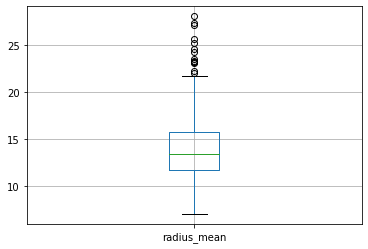

In [14]:
df_raw.boxplot(column="radius_mean")

The length of the whisker is either the 1.5 times the length of the box (as in the case of the upper whisker) or if there are no points at that distance, the distance to the most extreme point (as in the case of the lower whisker).

Therefore, all the points drawn as circles would be classified as outliers.

However, it was stated in the original paper for this dataset [1]:

> "All of the features are numerically modeled such that larger values will typically indicate a higher likelihood of malignancy"

Considering this, we have decided not to remove any outliers, as they are likely to represent extreme cases of malignant or benign breast masses.

### 1.4 Encoding categorical data

The "diagnosis" column is made up of objects, M or B. We need to encode this categorical data so that there is a single column which represents B as 0 and M as 1.

In [15]:
one_hot_df = pd.get_dummies(df_raw, drop_first=True)
one_hot_df.head()

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave_points_mean,symmetry_mean,fractal_dimension_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave_points_worst,symmetry_worst,fractal_dimension_worst,diagnosis_M
id,,,,,,,,,,,,,,,,,,,,,
842302,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,1
842517,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,1
84300903,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,1
84348301,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,1
84358402,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,1


The new column is called "diagnosis_M"

### 1.5 Feature scaling

We want to scale the features so that their mean is zero and their standard deviation is one. This can prevent models from over-weighting larger values and ignoring smaller ones, and can also help some models run faster [2].

In [16]:
# Set target and features
target = one_hot_df['diagnosis_M']
one_hot_df_indep = one_hot_df.drop('diagnosis_M', axis=1)

# Scale the features to have mean 0 and sd 1
std_features = (one_hot_df_indep.apply(lambda x : (x - np.mean(x)) / np.std(x)))
std_features.head()

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave_points_mean,symmetry_mean,fractal_dimension_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave_points_worst,symmetry_worst,fractal_dimension_worst
id,,,,,,,,,,,,,,,,,,,,,
842302,1.097064,-2.073335,1.269934,0.984375,1.568466,3.283515,2.652874,2.532475,2.217515,2.255747,...,1.886690,-1.359293,2.303601,2.001237,1.307686,2.616665,2.109526,2.296076,2.750622,1.937015
842517,1.829821,-0.353632,1.685955,1.908708,-0.826962,-0.487072,-0.023846,0.548144,0.001392,-0.868652,...,1.805927,-0.369203,1.535126,1.890489,-0.375612,-0.430444,-0.146749,1.087084,-0.243890,0.281190
84300903,1.579888,0.456187,1.566503,1.558884,0.942210,1.052926,1.363478,2.037231,0.939685,-0.398008,...,1.511870,-0.023974,1.347475,1.456285,0.527407,1.082932,0.854974,1.955000,1.152255,0.201391
84348301,-0.768909,0.253732,-0.592687,-0.764464,3.283553,3.402909,1.915897,1.451707,2.867383,4.910919,...,-0.281464,0.133984,-0.249939,-0.550021,3.394275,3.893397,1.989588,2.175786,6.046041,4.935010
84358402,1.750297,-1.151816,1.776573,1.826229,0.280372,0.539340,1.371011,1.428493,-0.009560,-0.562450,...,1.298575,-1.466770,1.338539,1.220724,0.220556,-0.313395,0.613179,0.729259,-0.868353,-0.397100


### 1.6 Splitting into train and test data

The final preprocessing step is to divide the dataset into train and test data. We have chosen to keep 20% of the data for testing.

In [17]:
# Split into train and test data
X = one_hot_df_indep.values
X_train, X_test, y_train, y_test  = train_test_split(X, target,
                                                     test_size = 0.2,
                                                    random_state=SEED)


### 1.7 Determining the threshold

There are a number of very important factors to consider when determining the threshold at which we diagnose a breast mass as malignant.

Firstly, a false negative means that we do not diagnose a tumor as malignant when it is, potentially risking the patients life as a result. However, it is highly unlikely that any time in the near future these algorithms alone will be diagnosing patients. Much more likely is that there will be a doctor working alongside, or with the aid of, a model and so this risk becomes less severe.

Secondly, a false positive means that we diagnose a benign tumor as malignant, and the patient is subjected to an unnecessary surgical biopsy, which has its own risks. 

Considering these factors, we have decided to set the threshold at 40%, i.e. any case which has a probability of being malignant over 40%, will be classified as malignant.

In [18]:
thresh = 0.4

## 2. Logistic Regression model

## 3. Decision Tree model

### 3.1 Tuning the hyperparameters
We will start by tuning some of the hyperparameters in order to achieve maximum accuracy with this model. This will be done by searching over a range of values for three of the hyperparameters of the Decision Tree[n] [n]:

* The criterion (criterion) - the function to measure the quality of a split. Supported criteria are “gini” for the Gini impurity and “entropy” for the information gain.
* The maximum depth of the tree (max_depth)
* The splitter (splitter) - the strategy used to choose the split at each node. Supported strategies are “best” to choose the best split and “random” to choose the best random split.

In [21]:
#Move the import to the import section on final report
from sklearn.tree import DecisionTreeClassifier

#Define Decision Tree Classifier 

decision_tree_criterion = ['gini', 'entropy']
decision_tree_splitter = ['best', 'random']
decision_tree_max_depth = [int(x) for x in np.linspace(5, 55, num = 5)]

decision_tree_params = {"criterion": decision_tree_criterion,
               "splitter": decision_tree_splitter,
               "max_depth": decision_tree_max_depth, 
              }


decision_tree = DecisionTreeClassifier(random_state=42)

decision_tree_random = GridSearchCV(decision_tree, decision_tree_params, cv=5, scoring='precision');


decision_tree_random.fit(X_train, y_train)



/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=DecisionTreeClassifier(class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort=False, random_state=42,
                                              splitter='best'),
             iid='warn', n_jobs=None,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [5, 17, 30, 42, 55],
                    

Now we can see what the best parameters are. 

In [22]:
decision_tree_params = decision_tree_random.best_params_
decision_tree_params

{'criterion': 'entropy', 'max_depth': 5, 'splitter': 'best'}

... and use them for our model. 

### 3.2 Running the model 

In [37]:
clf_decision_tree = DecisionTreeClassifier(random_state = 42,
                               criterion = decision_tree_params['criterion'],
                               splitter = decision_tree_params['splitter'],
                                max_depth = decision_tree_params['max_depth'])

clf_decision_tree.fit(X_train, y_train)

proba_clf_decision_tree = clf_decision_tree.predict_proba(X_test)
pred_clf_decision_tree = clf_decision_tree.predict(X_test)

### 3.3 Evalutating the model 

First, lets take a look at the accuracy, precision and AUC of the Decision Tree. 

In [38]:
print_metrics(y_test,pred_clf_decision_tree,proba_clf_decision_tree, "Decision Tree")

Decision Tree accuracy: 94.70%
Decision Tree precision: 88.00%
Decision Tree AUC: 0.9324


The AUC is another measure of how good the model is. The closer it is to one the better the model.

We can also plot the confusion matrix, which gives us a visual representation of how the model labelled the test data.

[[70  1]
 [ 5 38]]
Confusion matrix, without normalization
[[70  1]
 [ 5 38]]
Normalized confusion matrix
[[0.98591549 0.01408451]
 [0.11627907 0.88372093]]


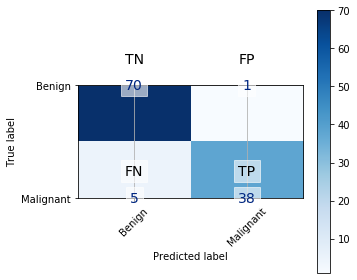

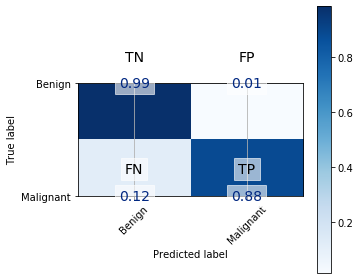

<Figure size 432x288 with 0 Axes>

In [40]:
#Confusion matrix, to see where our classifier is making mistakes:

print(metrics.confusion_matrix(y_test, pred_clf_decision_tree))

clf_decision_tree_conf = confusion_matrix(y_test,pred_clf_decision_tree)
plot_confusion_matrix(clf_decision_tree_conf, normalize=False)
plot_confusion_matrix(clf_decision_tree_conf, normalize=True)
plt.show()
plt.tight_layout()

We can also look at feature importance. This graph will show us which features were most important for the Decision Tree model in determining whether a mass was benign or malignant.

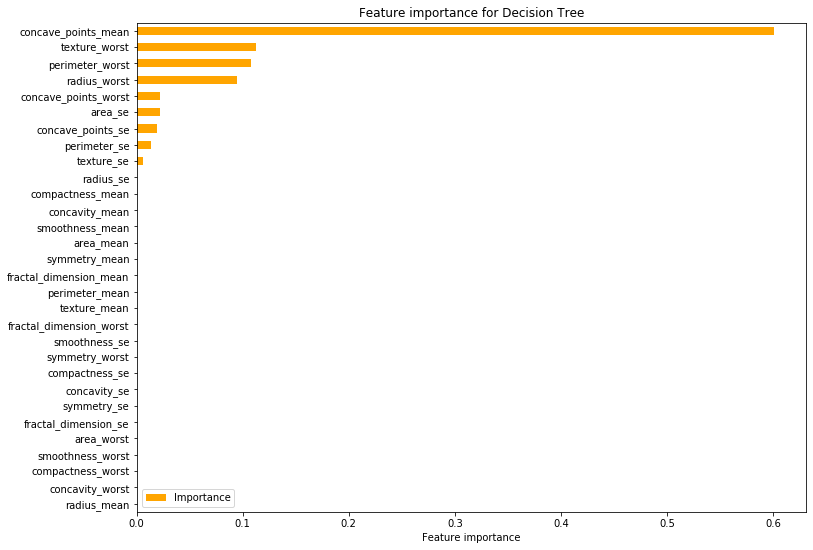

In [50]:
# Plot feature importance
from matplotlib import pyplot as plt
features_log = pd.DataFrame(clf_decision_tree.feature_importances_, index = one_hot_df_indep.columns.tolist(), 
                            columns = ['Importance'])
features_log = features_log.sort_values(by='Importance', ascending=True)

features_log.plot(kind='barh', figsize=(12,9), color = 'orange')
plt.xlabel('Feature importance')
plt.title('Feature importance for Decision Tree')
plt.show()

Finally, we can plot a visual decision tree plot. A decision tree is a flowchart-like structure in which each internal node represents a “test” on an attribute, each branch represents the outcome of the test, and each leaf node represents a class label (decision taken after computing all attributes). The paths from root to leaf represent classification rules.

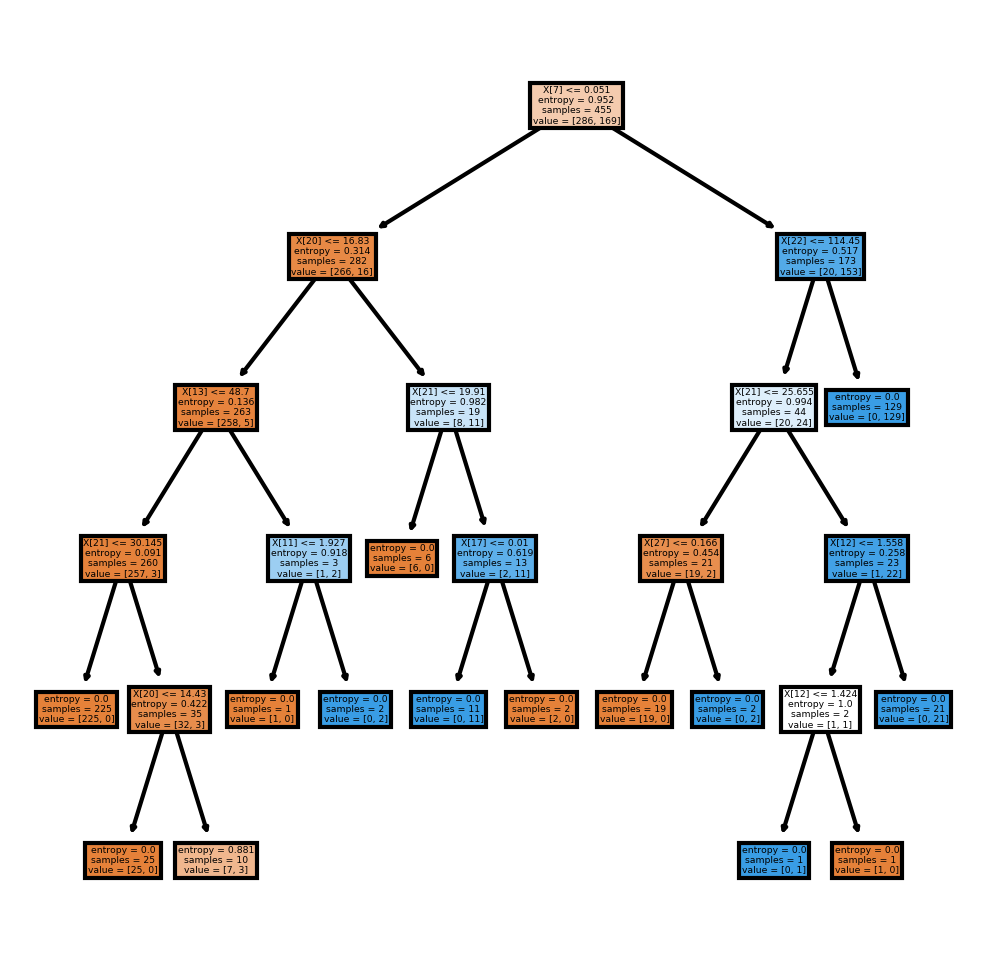

In [49]:
from sklearn import tree

fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (4,4), dpi=300)
tree.plot_tree(clf_decision_tree,
               filled = True);



## 4. Random Forest model

### 4.1 Tuning the hyperparameters

We will start by tuning some of the hyperparameters in order to achieve maximum accuracy with our model. This will be done by searching over a range of values for five of the hyperparameters of the Random Forest Classifier [n] [n]:
- The number of estimators (n_estimators) - the number of trees in the forest
- The maximum number of features (max_features) - the number of features to consider when looking for the best split
- The maximum depth of the tree (max_depth)
- The minimum number of samples required to split an internal node (min_sample_split)
- The minimum number of samples required to be at a leaf node (min_samples_leaf)

In [30]:
rf_n_estimators = [int(x) for x in np.linspace(start = 50, stop = 150, num = 11)]
rf_max_features = ['auto', 'sqrt']
rf_max_depth = [int(x) for x in np.linspace(5, 55, num = 5)]
rf_min_samples_split = [2, 5, 10]
rf_min_samples_leaf = [30, 40, 50]
rf_bootstrap = [True]

rf_random_params = {'n_estimators': rf_n_estimators,
               'max_features': rf_max_features,
               'max_depth': rf_max_depth,
               'min_samples_split': rf_min_samples_split,
               'min_samples_leaf': rf_min_samples_leaf,
               'bootstrap': rf_bootstrap,
               }

rf = RandomForestClassifier(random_state = SEED)

rf_random = RandomizedSearchCV(estimator = rf, 
                               param_distributions = rf_random_params, 
                               n_iter = 100, 
                               cv = 3, 
                               verbose=2, 
                               random_state=SEED, 
                               n_jobs = -1,
                               scoring="precision")

rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   19.8s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   45.6s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  1.2min finished
/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
                                                    n_estimators='warn',
                                                    n_jobs=None

Now we can see what the best choice of hyperparameters for our data is.

In [31]:
rf_params = rf_random.best_params_
rf_params

{'n_estimators': 100,
 'min_samples_split': 2,
 'min_samples_leaf': 30,
 'max_features': 'sqrt',
 'max_depth': 30,
 'bootstrap': True}

Now, we can use these for our model.

### 4.2 Running the model

In [32]:
clf_rf = RandomForestClassifier(random_state = 42,
                               n_estimators = rf_params['n_estimators'],
                               min_samples_split = rf_params['min_samples_split'],
                               min_samples_leaf = rf_params['min_samples_leaf'],
                               max_features = rf_params['max_features'],
                               max_depth = rf_params['max_depth'])

clf_rf.fit(X_train, y_train)

proba_clf_rf = clf_rf.predict_proba(X_test)
pred_clf_rf = np.where(proba_clf_rf[:,1] > thresh, 1, 0)

### 4.2 Evaluating the model

First, lets look at the accuracy, precision and AUC of the model.

In [33]:
print_metrics(y_test,pred_clf_rf,proba_clf_rf, "Random forest")

Random forest accuracy: 95.60%
Random forest precision: 95.00%
Random forest AUC: 0.9974


The AUC is another measure of how good the model is. The closer it is to one the better the model.

We can also plot the confusion matrix, which gives us a visual representation of how the model labelled the test data.

Confusion matrix, without normalization
[[68  3]
 [ 2 41]]
Normalized confusion matrix
[[0.95774648 0.04225352]
 [0.04651163 0.95348837]]


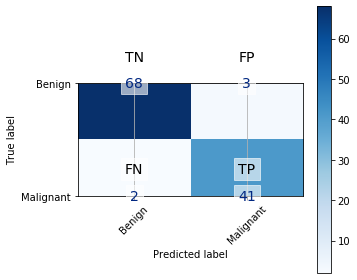

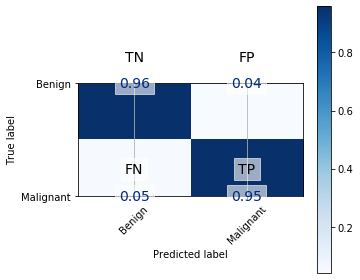

<Figure size 432x288 with 0 Axes>

In [34]:
clf_rf_conf = confusion_matrix(y_test,pred_clf_rf)
plot_confusion_matrix(clf_rf_conf, normalize=False)
plot_confusion_matrix(clf_rf_conf, normalize=True)
plt.show()
plt.tight_layout()

And finally, we can look at feature importance. This graph will show us which features were most important for the model in determining whether a mass was benign or malignant. 

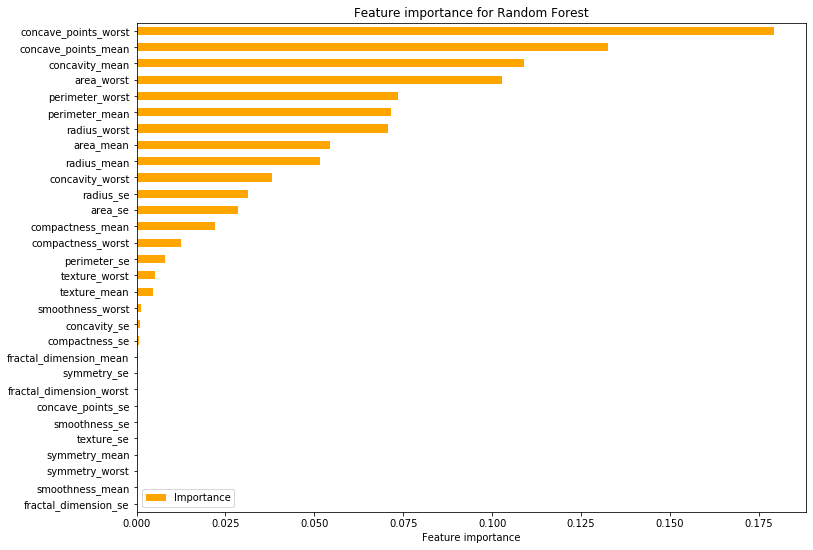

In [24]:
plot_feature_importance(clf_rf,"orange","Random Forest")
plt.show()

## 5. Multi-layer Perceptron

### 5.1 Tuning the hyperparameters

Here, we will search over four hyperparameters:

- The number and size of the hidden layers (hidden_layer_sizes)
- The maximum number of iterations (max_iter)
- The solver for weight optimisation (solver)
- The activation function for the hidden layer (activation)


In [ ]:
mlp_hidden_layer_sizes = np.arange(20,40,2)
mlp_max_iter = np.arange(200,800,100)
mlp_solver = ['lbfgs','adam']
mlp_activation = ['logistic','relu']
mlp_alpha = 10.0 ** -np.arange(1, 7)

mlp_grid = {'hidden_layer_sizes': mlp_hidden_layer_sizes,
               'max_iter': mlp_max_iter,
               'solver': mlp_solver,
               'activation': mlp_activation,
               'alpha': mlp_alpha}

clf_mlp = MLPClassifier(random_state=SEED)

mlp_grid_search = GridSearchCV(estimator = clf_mlp, 
                               param_grid = mlp_grid,
                               cv = 3, 
                               verbose=2,
                               n_jobs = -1,
                               scoring = 'precision')

mlp_grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 1440 candidates, totalling 4320 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   11.5s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done 1005 tasks      | elapsed:  6.2min
[Parallel(n_jobs=-1)]: Done 1450 tasks      | elapsed:  9.1min
[Parallel(n_jobs=-1)]: Done 1977 tasks      | elapsed: 11.5min
[Parallel(n_jobs=-1)]: Done 2584 tasks      | elapsed: 13.5min


And the optimum hyperparameters are:

In [32]:
mlp_params = mlp_grid_search.best_params_
mlp_params

{'activation': 'relu',
 'alpha': 0.001,
 'hidden_layer_sizes': 24,
 'max_iter': 400,
 'solver': 'adam'}

### 5.2 Evaluating the model

Let's look at the accuracy, precision and AUC.

In [33]:
proba_clf_mlp = mlp_grid_search.predict_proba(X_test)
pred_clf_mlp = np.where(proba_clf_mlp[:,1] > thresh, 1, 0)
print_metrics(y_test,pred_clf_mlp,proba_clf_mlp,"Multi-layer perceptron")

Multi-layer perceptron accuracy: 94.70%
Multi-layer perceptron precision: 93.00%
Multi-layer perceptron AUC: 0.9961


The confusion matrix:

In [35]:
clf_mlp_conf = confusion_matrix(y_test,pred_clf_mlp)
plot_confusion_matrix(clf_mlp_conf, normalize=False)
plot_confusion_matrix(clf_mlp_conf, normalize=True)
plt.show()
plt.tight_layout()

NameError: name 'pred_clf_mlp' is not defined

It's not possible to plot feature importance for the Multi-layer Perceptron classifier, so instead 

## 6. Conclusion

### 6.1 Comparing the models side-by-side

In order to pick the best model for the data, it is useful to compare the metrics.

First, lets compare the confusion matrices.

AttributeError: 'AxesSubplot' object has no attribute 'plot_confusion_matrix'

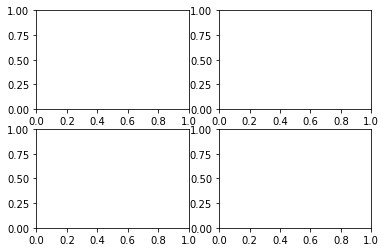

In [50]:
fig, axs = plt.subplots(2, 2)
axs[0, 0].plot_confusion_matrix(clf_mlp_conf, normalize=False)
axs[0, 0].set_title('Axis [0,0]')
axs[0, 1].plot(x, y, 'tab:orange')
axs[0, 1].set_title('Axis [0,1]')
axs[1, 0].plot(x, -y, 'tab:green')
axs[1, 0].set_title('Axis [1,0]')
axs[1, 1].plot(x, -y, 'tab:red')
axs[1, 1].set_title('Axis [1,1]')

for ax in axs.flat:
    ax.set(xlabel='x-label', ylabel='y-label')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

## 7. References

[[Section 0]](https://drive.google.com/drive/folders/1v7MpQQ8XrTkkKx2ef_oLQeL_61-4tafL) Google Drive Session 10: 10_model_evaluation_clean.ipynb

[[Section 1]](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.56.707&rep=rep1&type=pdf) W. Nick Street, William H. Wolberg, O. L. Mangasarian, (1992), Nuclear Feature Extraction For Breast Tumor Diagnosis, *International Symposium on Electronic Imaging: Science and Technology*, **1905**, 861-870

[[Section 1]](https://en.wikipedia.org/wiki/Feature_scaling#cite_note-:0-2) Wikipedia: Feature scaling

[[Section 4]](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) ScikitLearn: Random Forest Classifier

[[Section 4]](https://github.com/EmilyJonesQB/cfg-session-9) Github: EmilyJonesQB > 5_predictive_analysis_updated_answers.ipynb
